<div class="alert alert-block alert-warning">
    <b>Warning:</b> The content of the note may contain copyrighted material. Do not distribute.
</div>

# Applications: Effect of Bond Issuance on Firms' Performance

Seho Jeong, Sogang University

**References**
- **Darmouni, Olivier, and Kerry Y. Siani. 2025.** "Bond Market Stimulus: Firm-Level Evidence." Journal of Monetary Economics, 151: 103728. https://www.sciencedirect.com/science/article/pii/S0304393224001818.
- **Princeton LibGuides. n.d.** "Event Study with Stata: A Step-by-Step Guide." Princeton University Library. https://libguides.princeton.edu/eventstudy.
- **Miller, Douglas L. 2023.** "An Introductory Guide to Event Study Models." Journal of Economic Perspectives, 37(2): 203-230. 
- **Nguyen, Mike. 2020.** "A Guide on Data Analysis." Bookdown. https://bookdown.org/mike/data_analysis/
- **Clarke, Damian, and Kathya Tapia Schythe. 2020.** "Implementing the Panel Event Study." IZA Institute of Labor Economics Discussion Paper Series. https://docs.iza.org/dp13524.pdf

The panel event study is an extension of the standard difference-in-differences model, where a single **PostEvent** indicator is included for all periods posterior to the occurrence of the event in treated states. This is simply: $$y_{it} = \alpha + \beta \text{PostEvent}_{it} + $$

In [174]:
# Import libraries.
import numpy as np
import pandas as pd
import statsmodels.api as sm
import linearmodels as lm
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

import requests
import FinanceDataReader as fdr

In [175]:
pd.set_option('display.max_columns', None)

In [176]:
bg = '#F9F9F9'

## A Naive Introduction to Event Study

An event study typically tries to examine return behavior for a sample of firms experiencing a common type of event (e.g., a stock split). The event might take place at different points in calendar time or it might be clustered at a particular date (e.g., a regulatory event affecting an industry or a subset of the population of firms).

Let $t=0$ represent the time of the event. For each sample stock $i$, the stock return for time period $t$ relative to the event, $R_{it}$, is $$R_{it} = K_{it} + e_{it}$$ where $K_{it}$ is the normal (i.e., expected or predicted return given the model of expected returns), and $e_{it}$ is the component of returns which is abnormal or unexpected. A model of normal returns must be specified before an abnormal return can be defined.

Given this return decomposition, the abnormal return, $e_{it}$ , is the difference between the observed return and the predicted return $$e_{it} = R_{it} - K_{it}.$$ Thus the abnormal return is a direct measure of the (unexpected) change in securityholder wealth associated with the event. 

### Key Assumptions

Event study requires some assumptions to be correctly conducted:

- **efficient market hypothesis (EMH)**: Stock prices fully reflect available information (Fama, 1970);
- **stock market as a proxy for firm value**: Shareholders are the primary stakeholders;
- **sharp event effect**: The event must cause an immediate stock price reaction;
- **proper calculation of expected stock returns**: Event study requires an appropriate benchmark model.

### Applications Across Disciplines

Event studies have been applied extensively in management, marketing, and finance to assess how different corporate and external events influence shareholder value.



## Data Preparation

You may have downloaded datasets for an event study, or created ones by entering data into spreadsheets. Usually, people have two files, one for stock returns, and other for your event of interest. In this example, we start with two datasets, one called `eventdates` and the other called `stockdata`. In the `eventdates` data, we have company id (`company_id`) and the date of event (`event_date`) as variables. In the stock data, we have matching company id (`company_id`), stock return date (`date`), stock return (`ret`), and market return value (`market_return`).

If a set of observations for each company can be matched to a single event date, the study will be much simpler. In some situations, one may wish to examine more than one event date for each company. In multiple observations per company, it is necessary to create a duplicate set of observations for each (event date, company) combination. You need a full set of stock observations to examine each event.

If you already know that you have only one event for each company, you may skip subsections "" and "" below, merge your own `eventdate` and `stockdata` data files, and go to next section for the step-by-step procedure to conduct the event study.

### Download and Cleaning Data

You can enhance the code performance by parallelization. Here we do not consider high performance computing.

In [134]:
# Load the API key.
with open('../keys.txt', 'r') as f:
    line = f.readlines()[0]
    api_key = line.split(': ')[1].replace('\n', '')

In [135]:
def get_total_count(url, params):
    response = requests.get(url, params=params)
    total_count = response.json()['response']['body']['totalCount']
    return total_count

def download_data(url, params_list, print_status=True):
    # Download the data.
    data = []
    if print_status:
        for params in tqdm(params_list):
            response = requests.get(url, params=params)
            data += response.json()['response']['body']['items']['item']
    else:
        for params in params_list:
            response = requests.get(url, params=params)
            data += response.json()['response']['body']['items']['item']

    # Return data as a DataFrame.
    df = pd.DataFrame(data)
    return df

Often continuous variables in the dataset are winsorized. **Winsorizing** is the transformation of values by limiting extreme values in the data to reduce the effect of possibly spurious outliers. Instead of dropping extreme observations, we instead replacing it with certain limit points.

In [136]:
def winsorize(series):

    q_min = series.quantile(q=0.01)
    q_max = series.quantile(q=0.99)

    series[series < q_min] = q_min
    series[series > q_max] = q_max

    return series

#### Basic Information

In [22]:
# Collect corporate basic info data. (10 min.)
url = 'http://apis.data.go.kr/1160100/service/GetCorpBasicInfoService_V2/getCorpOutline_V2'
params_list = [{'ServiceKey': api_key,
                'pageNo': i+1,
                'numOfRows': 10000,
                'resultType': 'json'} for i in range(110)]

static_info = download_data(url, params_list)

  0%|          | 0/110 [00:00<?, ?it/s]

In [23]:
# Clean the corporate registration number.
static_info.replace(['0000000000000', '9999999999999'], np.nan, inplace=True)

In [24]:
# Save the static firm information into csv.
static_info.to_csv('../data/day5/static_info.csv', index=None)

In [178]:
# static_info = pd.read_csv('../data/day5/static_info.csv', dtype=str)

In [179]:
static_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1074236 entries, 0 to 1074235
Data columns (total 37 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   crno                 1074221 non-null  object
 1   corpNm               1074234 non-null  object
 2   corpEnsnNm           595313 non-null   object
 3   enpPbanCmpyNm        156222 non-null   object
 4   enpRprFnm            948983 non-null   object
 5   corpRegMrktDcd       156222 non-null   object
 6   corpRegMrktDcdNm     156222 non-null   object
 7   corpDcd              314725 non-null   object
 8   corpDcdNm            314724 non-null   object
 9   bzno                 949218 non-null   object
 10  enpOzpno             949361 non-null   object
 11  enpBsadr             1002835 non-null  object
 12  enpDtadr             815417 non-null   object
 13  enpHmpgUrl           122675 non-null   object
 14  enpTlno              941484 non-null   object
 15  enpFxno        

#### Bond Issuance Information

In [25]:
# Collect corporate bond issuance data.
url = 'http://apis.data.go.kr/1160100/service/GetBondTradInfoService/getIssuIssuItemStat'
params_list = [{'serviceKey': api_key,
                'pageNo': 1,
                'numOfRows': 1,
                'resultType': 'json'}]
params_list[0]['numOfRows'] = get_total_count(url, params_list[0])
bond_issue = download_data(url, params_list)

  0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
# Clean dates with errors.
bond_issue.replace(['', '00000101', '99981230', '99991230'], np.nan, inplace=True)
bond_issue['bondIssuDt'] = pd.to_datetime(bond_issue['bondIssuDt'], format='%Y%m%d', errors='coerce')
bond_issue['bondExprDt'] = pd.to_datetime(bond_issue['bondExprDt'], format='%Y%m%d', errors='coerce')

# Clean the corporate registration number.
bond_issue.replace(['0000000000000', '9999999999999'], np.nan, inplace=True)

In [27]:
# Save the bond issuance data into csv.
bond_issue.to_csv('../data/day5/bond_issue.csv', index=None)

In [181]:
# bond_issue = pd.read_csv('../data/day5/bond_issue.csv', dtype=str)

In [182]:
bond_issue.head()

,basDt,crno,scrsItmsKcd,isinCd,scrsItmsKcdNm,bondIsurNm,isinCdNm,bondIssuDt,bondIssuFrmtNm,bondIssuAmt,bondIssuCurCd,bondIssuCurCdNm,bondExprDt,bondPymtAmt,irtChngDcd,irtChngDcdNm,bondSrfcInrt,bondIntTcd,bondIntTcdNm
0,20200715,1101110168595,1108,KR6010141911,일반회사채,삼성중공업,삼성중공업 101(사모),2019-01-16,공사채등록,10000000000,KRW,KRW,2020-07-16,10000000000,1,고정,4.2,1,이표채
1,20200715,1101110377203,1105,KR60659026A3,금융채,현대카드,현대카드 669-1,2016-10-18,전자증권,80000000000,KRW,KRW,2020-07-16,80000000000,1,고정,1.934,1,이표채
2,20200715,1101110672538,1105,KR6004944874,금융채,하나은행,하나은행 41-07이2갑-16,2018-07-16,공사채등록,150000000000,KRW,KRW,2020-07-16,150000000000,1,고정,2.19,1,이표채
3,20200715,1101112615578,1108,KR6140411572,일반회사채,메지온,메지온 1(사모/전/콜/풋),2015-07-16,실물발행,42000000000,KRW,KRW,2020-07-16,42000000000,1,고정,0,1,이표채
4,20200715,1101114546523,1105,KR6140173578,금융채,KB국민카드,케이비국민카드 132-3,2015-07-16,전자증권,20000000000,KRW,KRW,2020-07-16,20000000000,1,고정,2.41,1,이표채


We will only consider vanilla corporate bonds (`일반회사채`) for our event analysis. Thus in our dataset, we only keep rows with `일반회사채` in the column `isinCd`. We also drop bonds issued in currencies other than KRW.

In [183]:
event_bond = bond_issue.loc[(bond_issue.scrsItmsKcdNm=='일반회사채') & (bond_issue.bondIssuCurCdNm=='KRW'), :].reset_index(drop=True)

In [184]:
event_bond.head()

,basDt,crno,scrsItmsKcd,isinCd,scrsItmsKcdNm,bondIsurNm,isinCdNm,bondIssuDt,bondIssuFrmtNm,bondIssuAmt,bondIssuCurCd,bondIssuCurCdNm,bondExprDt,bondPymtAmt,irtChngDcd,irtChngDcdNm,bondSrfcInrt,bondIntTcd,bondIntTcdNm
0,20200715,1101110168595,1108,KR6010141911,일반회사채,삼성중공업,삼성중공업 101(사모),2019-01-16,공사채등록,10000000000,KRW,KRW,2020-07-16,10000000000,1,고정,4.2,1,이표채
1,20200715,1101112615578,1108,KR6140411572,일반회사채,메지온,메지온 1(사모/전/콜/풋),2015-07-16,실물발행,42000000000,KRW,KRW,2020-07-16,42000000000,1,고정,0,1,이표채
2,20200715,1101116837772,1108,KR6310102977,일반회사채,키움캐피탈,키움캐피탈 28(사모),2019-07-16,공사채등록,5000000000,KRW,KRW,2020-07-16,5000000000,1,고정,3.1,1,이표채
3,20200716,1101110003668,1108,KR6002322875,일반회사채,한진,한진 84-2(사모),2018-07-18,공사채등록,10000000000,KRW,KRW,2020-07-17,10000000000,1,고정,4.45,1,이표채
4,20200716,1101111840928,1108,KR6039671575,일반회사채,한류타임즈,스포츠서울 12(사모/전/풋),2015-07-17,공사채등록,4000000000,KRW,KRW,2020-07-17,4000000000,1,고정,5.5,1,이표채


In [185]:
merge_key = list(set(event_bond.crno.dropna().unique()) & set(static_info.crno.dropna().unique()))
event_bond = event_bond.loc[event_bond.crno.isin(merge_key), :].reset_index(drop=True)
static_info = static_info.loc[static_info.crno.isin(merge_key), :].reset_index(drop=True)

print(f'Number of our (current) sample of firms is {len(merge_key)}.')

Number of our (current) sample of firms is 7829.


#### Stock Data

In [186]:
crno_keys = pd.read_csv('../data/day5/crno_keys.csv', index_col='Unnamed: 0', dtype=str)

In [187]:
crno_keys['crno'] = crno_keys['crno'].str[:-2]

In [188]:
crno_keys.head()

,firm_name,crno,brno,ticker
0,신라교역,1101110008254,219-81-00919,004970
1,농우바이오,1301110015049,124-81-16938,054050
2,아시아종묘,1101113036096,215-86-58597,154030
3,동원수산,1101110046204,220-81-09792,030720
4,삼성수산,1101111385510,229-81-26352,052560


In [189]:
merge_key = list(set(merge_key) & set(crno_keys.crno.dropna().unique()))
static_info = static_info.loc[static_info.crno.isin(merge_key), :].reset_index(drop=True)
event_bond = event_bond.loc[event_bond.crno.isin(merge_key), :].reset_index(drop=True)
crno_keys = crno_keys.loc[crno_keys.crno.isin(merge_key), :].reset_index(drop=True)

print(f'Number of our (current) sample of firms is {len(merge_key)}.')

Number of our (current) sample of firms is 1510.


In [123]:
# Download the stock price data.
stock_price = pd.DataFrame()

for ticker in tqdm(crno_keys.ticker):
    df = fdr.DataReader(ticker)
    try:
        close = df.Close
    except AttributeError as e:
        print(f'Error {ticker}: {e}')
        continue
    stock_price = pd.concat([stock_price, close.rename(ticker)], axis=1)

  0%|          | 0/1510 [00:00<?, ?it/s]

"001110" invalid symbol or has no data
Error 001110: 'DataFrame' object has no attribute 'Close'
"062760" invalid symbol or has no data
Error 062760: 'DataFrame' object has no attribute 'Close'
"068560" invalid symbol or has no data
Error 068560: 'DataFrame' object has no attribute 'Close'
"101910" invalid symbol or has no data
Error 101910: 'DataFrame' object has no attribute 'Close'
"323530" invalid symbol or has no data
Error 323530: 'DataFrame' object has no attribute 'Close'
"363170" invalid symbol or has no data
Error 363170: 'DataFrame' object has no attribute 'Close'
"012720" invalid symbol or has no data
Error 012720: 'DataFrame' object has no attribute 'Close'
"010090" invalid symbol or has no data
Error 010090: 'DataFrame' object has no attribute 'Close'
"037090" invalid symbol or has no data
Error 037090: 'DataFrame' object has no attribute 'Close'
"065050" invalid symbol or has no data
Error 065050: 'DataFrame' object has no attribute 'Close'
"025080" invalid symbol or has

In [ ]:
stock_price.to_csv('../data/day5/stock_price.csv')

In [190]:
# stock_price.to_csv('../data/day5/stock_price.csv', index=None)
stock_price = pd.read_csv('../data/day5/stock_price.csv')

In [191]:
# Keep the sample of firms.
crno_keys = crno_keys.loc[crno_keys.ticker.isin(stock_price.columns), :].reset_index(drop=True)

merge_key = list(crno_keys.crno)
static_info = static_info.loc[static_info.crno.isin(merge_key), :].reset_index(drop=True)
event_bond = event_bond.loc[event_bond.crno.isin(merge_key), :].reset_index(drop=True)

print(f'Number of our (current) sample of firms is {len(merge_key)}.')

Number of our (current) sample of firms is 1499.


In [194]:
ret = stock_price.pct_change()

/var/folders/n5/bkphn15s0kzc1lsr8x64v8y00000gn/T/ipykernel_1635/1469535877.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret = stock_price.pct_change()


In [195]:
ret

154030    000660  207940  373220    012450    005380    034020  \
0          NaN       NaN     NaN     NaN       NaN       NaN       NaN   
1    -0.053950 -0.041426     NaN     NaN -0.007699 -0.006652 -0.019277   
2    -0.134420 -0.009045     NaN     NaN -0.013591  0.020089  0.007514   
3    -0.149412 -0.007099     NaN     NaN -0.030514 -0.019694 -0.025476   
4    -0.114799  0.008172     NaN     NaN  0.013196 -0.004464 -0.001571   
...        ...       ...     ...     ...       ...       ...       ...   
5807  0.000000  0.000000     0.0     0.0  0.000000  0.000000  0.000000   
5808  0.000000  0.000000     0.0     0.0  0.000000  0.000000  0.000000   
5809  0.000000  0.000000     0.0     0.0  0.000000  0.000000  0.000000   
5810  0.000000  0.000000     0.0     0.0  0.000000  0.000000  0.000000   
5811  0.000000  0.000000     0.0     0.0  0.000000  0.000000  0.000000   

        000270  329180    012330    005490    042660    064350    051910  \
0          NaN     NaN       NaN       NaN       NaN       NaN       NaN   
1    -0.005525     NaN -0.001835 -0.014778  0.011606 -0.020599  0.003534   
2     0.003704     NaN  0.027574  0.001667 -0.038299  0.019120  0.012324   
3     0.003690     NaN -0.025045 -0.019967 -0.045834 -0.022514 -0.012174   
4    -0.016544     NaN  0.003670 -0.010187  0.000000 -0.021113 -0.019366   
...        ...     ...       ...       ...       ...       ...       ...   
5807  0.000000     0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
5808  0.000000     0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
5809  0.000000     0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
5810  0.000000     0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
5811  0.000000     0.0  0.000000  0.000000  0.000000  0.000000  0.000000   

        033780  267260    096770    010140    010130    006400  079550  \
0          NaN     NaN       NaN       NaN       NaN       NaN     NaN   
1     0.020000     NaN -0.019418 -0.005605  0.028786 -0.023809     NaN   
2     0.010893     NaN -0.004951 -0.024252  0.038929  0.015247     NaN   
3     0.000000     NaN -0.005977 -0.034499  0.002342  0.006006     NaN   
4     0.021552     NaN -0.000997  0.001976  0.004673  0.026862     NaN   
...        ...     ...       ...       ...       ...       ...     ...   
5807  0.000000     0.0  0.000000  0.000000  0.000000  0.000000     0.0   
5808  0.000000     0.0  0.000000  0.000000  0.000000  0.000000     0.0   
5809  0.000000     0.0  0.000000  0.000000  0.000000  0.000000     0.0   
5810  0.000000     0.0  0.000000  0.000000  0.000000  0.000000     0.0   
5811  0.000000     0.0  0.000000  0.000000  0.000000  0.000000     0.0   

        066570    003670    003230  272210  247540  298040    047810  \
0          NaN       NaN       NaN     NaN     NaN     NaN       NaN   
1    -0.048906 -0.004455  0.010345     NaN     NaN     NaN  0.001546   
2    -0.005413 -0.022235 -0.006826     NaN     NaN     NaN  0.001543   
3    -0.009524 -0.023527  0.000000     NaN     NaN     NaN -0.004622   
4    -0.006868  0.006737  0.085911     NaN     NaN     NaN  0.009288   
...        ...       ...       ...     ...     ...     ...       ...   
5807  0.000000  0.000000  0.000000     0.0     0.0     0.0  0.000000   
5808  0.000000  0.000000  0.000000     0.0     0.0     0.0  0.000000   
5809  0.000000  0.000000  0.000000     0.0     0.0     0.0  0.000000   
5810  0.000000  0.000000  0.000000     0.0     0.0     0.0  0.000000   
5811  0.000000  0.000000  0.000000     0.0     0.0     0.0  0.000000   

        042700    010120    028300    010950    000880    009830  214450  \
0          NaN       NaN       NaN       NaN       NaN       NaN     NaN   
1    -0.017007 -0.009036  0.008080 -0.009009 -0.026822 -0.013843     NaN   
2    -0.010381  0.015198  0.000943 -0.005455 -0.017726  0.005605     NaN   
3     0.006993 -0.022455  0.000000 -0.009141  0.018046 -0.022297     NaN   
4    -0.006944 -0.001531 -0.016957  0.000000 -0.007892  0.005701     NaN

In [246]:
# Drop rows with NA values for daily return.
stock_price.dropna(subset=['daily_return'], inplace=True, ignore_index=True)

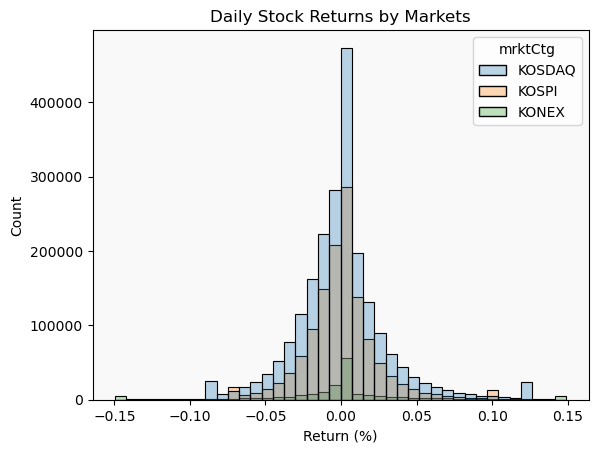

In [247]:
# Draw a plot of distriubtion of stock returns.
fig, ax = plt.subplots()

wret = stock_price.copy()
wret.loc[wret.mrktCtg == 'KOSPI', 'daily_return'] = winsorize(wret.loc[wret.mrktCtg == 'KOSPI', 'daily_return'])
wret.loc[wret.mrktCtg == 'KOSDAQ', 'daily_return'] = winsorize(wret.loc[wret.mrktCtg == 'KOSDAQ', 'daily_return'])
wret.loc[wret.mrktCtg == 'KONEX', 'daily_return'] = winsorize(wret.loc[wret.mrktCtg == 'KONEX', 'daily_return'])

sns.histplot(x='daily_return', data=wret, hue='mrktCtg', alpha=0.3, ax=ax, fill=True, bins=40)

ax.set_facecolor(bg)
ax.set_title('Daily Stock Returns by Markets')
ax.set_xlabel('Return (%)')

plt.show()

#### Market Return Data

In [248]:
# Download stock market index data.
kospi = fdr.DataReader('KS11', '2020-01-01', '2025-07-25')
kosdaq = fdr.DataReader('KQ11', '2020-01-01', '2025-07-25')

# Compute daily market returns.
ret_kospi = kospi.Close.pct_change().rename('ks_daily_return').dropna()
ret_kosdaq = kosdaq.Close.pct_change().rename('kq_daily_return').dropna()

# Concatenate two returns data.
mkt_returns = pd.concat([
    pd.DataFrame({'basDt': ret_kospi.index, 'mrktCtg': 'KOSPI', 'mkt_return': ret_kospi.values}),
    pd.DataFrame({'basDt': ret_kosdaq.index, 'mrktCtg': 'KOSDAQ', 'mkt_return': ret_kosdaq.values})
])

In [249]:
# Merge market return with individual stock price data.
stock_price = stock_price.merge(mkt_returns, on=['basDt', 'mrktCtg'], how='left')

In [401]:
ret = stock_price.loc[:, ['isinCd', 'basDt', 'daily_return', 'mkt_return']]

In [402]:
ret

,isinCd,basDt,daily_return,mkt_return
0,HK0000214814,2020-01-03,0.004630,-0.006068
1,HK0000214814,2020-01-06,-0.027650,-0.021823
2,HK0000214814,2020-01-07,0.033175,0.012406
3,HK0000214814,2020-01-08,-0.068807,-0.033914
4,HK0000214814,2020-01-09,0.049261,0.039239
...,...,...,...,...
3634175,KYG2115T1076,2025-07-18,0.007692,0.002933
3634176,KYG2115T1076,2025-07-21,-0.010905,0.001243
3634177,KYG2115T1076,2025-07-22,0.008820,-0.010612
3634178,KYG2115T1076,2025-07-23,-0.008743,0.000726


#### Accounting Data

#### Choice of Sample Firms

In [252]:
firm_id = list(set(equity_issue.crno.dropna()) & set(static_info.crno.dropna()) & set(bond_issue.crno.dropna()))
print(f'Number of sample firms: {len(firm_id)}')

Number of sample firms: 1728


In [253]:
si = static_info.loc[static_info.crno.isin(firm_id), :].sort_values(by='crno').reset_index(drop=True)
ei = equity_issue.loc[equity_issue.crno.isin(firm_id), :].sort_values(by='crno').reset_index(drop=True)
bi = bond_issue.loc[bond_issue.crno.isin(firm_id), :].sort_values(by='crno').reset_index(drop=True)

We have a stock price data from year 2020. Thus we restrict event date that is after the January 1st, 2020.

In [254]:
ei = ei.loc[ei.stckIssuDt > '2020-01-01', :].reset_index(drop=True)
bi = bi.loc[bi.bondIssuDt > '2020-01-01', :].reset_index(drop=True)

## Exploratory Data Analysis

Exploratory data analysis (EDA) involves taking a first look at a dataset and summarizing its salient characteristics using tables and graphs. It is (or should be) the stage before testing hypotheses and can be useful in informing hypotheses. In this section, we will look up the data we have downloaded in the previous section using a few options for EDA using Python.

There are some things we should do even before an EDA; we should make sure we've cast the columns to the right types and converted any that need converting. If ready, let's begin!

### Exploratory Tables and Descriptive Statistics

A small step beyond `df.info()` to get tables is to use `df.describe()` which, if you have mixed data types that include floats, will report some basic summary statistics:

In [ ]:
df.describe()

## Effects of Bond Issuance on Stock Returns

### Step 1: Event Identification

An event study examines how a particular event affects a firm's stock price, assuming that stock markets incorporate new information efficiently. The event must influence either the firm's expected cash flows or dicount rate.

First, we need to find out how many event dates there are for each company. Use the datasets of event dates and generate a variable that counts the number of event dates per company.

In [255]:
# Count number of equity issuance by crno.
equity_count = ei.groupby('crno').count()
equity_count = equity_count['basDt']
equity_count.name = 'equity_count'

# Count number of bond issuance by crno.
bond_count = bi.groupby('crno').count()
bond_count = bond_count['basDt']
bond_count.name = 'bond_count'

# Print the summary statistics of issuances.
equity_summary = equity_count.describe()
bond_summary = bond_count.describe()
print(f'[01] Number of issuances: Equity = {equity_count.sum():7d}, Bond = {bond_count.sum():7d}')
print(f'[02] Number of firms:     Equity = {int(equity_summary['count']):7d}, Bond = {int(bond_summary['count']):7d}')
print(f'[03] Mean:                Equity = {equity_summary['mean']:7.1f}, Bond = {bond_summary['mean']:7.1f}')
print(f'[04] Std. dev.:           Equity = {equity_summary['std']:7.1f}, Bond = {bond_summary['std']:7.1f}')
print(f'[05] Min.:                Equity = {equity_summary['min']:7.1f}, Bond = {bond_summary['min']:7.1f}')
print(f'[06] 25%:                 Equity = {equity_summary['25%']:7.1f}, Bond = {bond_summary['25%']:7.1f}')
print(f'[07] 50%:                 Equity = {equity_summary['50%']:7.1f}, Bond = {bond_summary['50%']:7.1f}')
print(f'[08] 75%:                 Equity = {equity_summary['75%']:7.1f}, Bond = {bond_summary['75%']:7.1f}')
print(f'[09] Max.:                Equity = {equity_summary['max']:7.1f}, Bond = {bond_summary['max']:7.1f}')

[01] Number of issuances: Equity =   25357, Bond =    9475
[02] Number of firms:     Equity =    1469, Bond =    1493
[03] Mean:                Equity =    17.3, Bond =     6.3
[04] Std. dev.:           Equity =    31.5, Bond =    34.9
[05] Min.:                Equity =     1.0, Bond =     1.0
[06] 25%:                 Equity =     3.0, Bond =     1.0
[07] 50%:                 Equity =     8.0, Bond =     2.0
[08] 75%:                 Equity =    20.0, Bond =     5.0
[09] Max.:                Equity =   518.0, Bond =  1011.0


In [314]:
ei

,basDt,crno,isinCd,stckIssuCmpyNm,isinCdNm,scrsItmsKcd,scrsItmsKcdNm,issuStckCnt,lstgDt,stckIssuDt,stckIssuDcnt,stckIssuRcd,stckIssuRcdNm,scrsDcd,stckIssuSqno
0,20250725,1101110002694,KR7006360002,지에스건설,지에스건설,0101,보통주,324438,2021-02-19,2021-01-28,18,901,국내CB행사,21,74
1,20250725,1101110002694,KR7006360002,지에스건설,지에스건설,0101,보통주,202773,2021-03-19,2021-02-02,18,901,국내CB행사,21,75
2,20210512,1101110002694,KR7006360002,지에스건설,지에스건설,0101,보통주,90622,NaT,2021-02-24,19,903,해외CB행사,21,14
3,20250725,1101110002694,KR7006360002,지에스건설,지에스건설,0101,보통주,191401,2021-01-04,2020-12-11,19,903,해외CB행사,21,4
4,20250725,1101110002694,KR7006360002,지에스건설,지에스건설,0101,보통주,114841,2021-01-20,2020-12-30,19,903,해외CB행사,21,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25352,20250725,2850110287959,KR7263050007,유틸렉스,유틸렉스,0101,보통주,71998,2022-08-18,2022-08-01,32,301,주식전환,21,4
25353,20250725,2850110287959,KR7263050007,유틸렉스,유틸렉스,0101,보통주,467986,2022-08-18,2022-08-02,32,301,주식전환,21,5
25354,20250725,2850110287959,KR7263050007,유틸렉스,유틸렉스,0101,보통주,179998,2022-08-25,2022-08-09,32,301,주식전환,21,6
25355,20250725,2850110287959,KR7263050007,유틸렉스,유틸렉스,0101,보통주,6672,2021-05-03,2021-04-05,24,905,STOCKOPTION행사,21,1


In [398]:
event = ei.loc[ei.stckIssuRcdNm == '액면분할', ['isinCd', 'stckIssuDt']]
event.columns = ['isinCd', 'eventDt']
event = event.sort_values(by=['isinCd', 'eventDt']).reset_index(drop=True)
event.drop_duplicates(inplace=True)

In [399]:
ei.stckIssuRcdNm.unique()

array(['국내CB행사', '해외CB행사', '이익소각', '무상소각', '주식교환', '무상증자', '액면분할', '합병',
       '자본감소', '유상증자', '회사분할', '국내BW행사', '상호변경', '배당/분배', '주식전환', '분할합병',
       '액면병합', 'STOCKOPTION행사', '사무인수'], dtype=object)

In [400]:
event

,isinCd,eventDt
0,KR7000480004,2023-04-08
1,KR7000520007,2021-04-09
2,KR7001390004,2023-08-24
3,KR7001790005,2021-04-13
4,KR7001791003,2021-04-13
...,...,...
91,KR7378340004,2022-04-12
92,KR7403550007,2021-12-04
93,KR7406820001,2022-06-03
94,KR7417180007,2022-04-12


Cut the dataset down to just one observation for each company. Each company observation is associated with the count of event dates for that company. Save this as a new dataset &mdash; don't overwrite your dataset of event dates!

The next step is to merge the new `eventcount` datset with your dataset of stock data.

Now use Python's `expand` method to create the duplicate observations. The `eventcount` variable has been merged on to each stock observation, and tells computer how many copies of that observation are needed. This is where your dataset can get very big, as we are 

### Step 2: Define the Event and Estimation Windows

It's likely that you have more observations for each company than you need. It's also possible that you do not have enough for some. Before you continue, you must make sure that you will be conducting your analyses on the correct observations. To do this, you will need to create a variable ,`dif`, that will count the number of days from the observation to the event date. This can be either calendar days or trading days.

#### Estimation Window

The estimation window is used to compute normal (expected) returns before the event. Johnston (2007) used 250 days before the event, with a 45-day gap before the event window. Wiles, Morgan, and Rego (2012) set 90-trading-day estimation window ending 6 days before the event. A. Sorescu, Warren, and Ertekin (2017) used 100 days before the event. To avoid biases from information leaking before the event, researchers should check broad news sources for pre-event rumors.

Here we set estimation window as 100 days before the event.

In [403]:
estimation_size = 100 # size of estimation window

In [404]:
event['estimateDt'] = event['eventDt'] - pd.Timedelta(days=100)

In [405]:
# Drop events with missing estimation dates.
event = event.loc[event.estimateDt > '2020-01-01', :].reset_index(drop=True)

Now we are at the point where we can actually start an analysis. First we need a way to estimate *normal performance*. To do this, we will run a separate regression for each company using the data within the estimation window and save the alphas (the intercept) and betas (the coefficient of the independent variable). We will later use these saved regression equations to predict normal performance during the event window.

Note that return, the dependent variable in our regression, is simply a given stock's return, while the independent variable `vretd` that we use to predict `ret` is the value-weighted return of an index whatever exchange the stock trades on.

Here, we created a variable `id` that numbers the companies from 1 to however many there are. The `N` is the number of company-event combinations that have complete data. This process iterates over the companies, runs a regression in the estimation window for each, and then uses that regression to predict a normal return in the event window.

In [377]:
event

,isinCd,eventDt,estimateDt
0,KR7000040006,2020-05-12,2020-02-02
1,KR7000040006,2024-04-27,2024-01-18
2,KR7000040006,2024-05-01,2024-01-22
3,KR7000040006,2024-05-11,2024-02-01
4,KR7000060004,2020-11-14,2020-08-06
...,...,...,...
2370,KR7489730002,2024-11-22,2024-08-14
2371,KR7492220009,2024-12-06,2024-08-28
2372,KR7493790000,2025-01-17,2024-10-09
2373,KR7496070004,2025-05-23,2025-02-12


#### Event Window

The event window captures the market's reaction to the event. The selection of an appropriate window lengths depends on event type and information speed. For instance, Balasubramaniann, Marthur, and Thakur (2005), Boyd, Chandy, and Cunha Jr. (2010), and Fornell et al. (2006) used 1-day window, Raassens, Wuyts, and Geyskens (2012) and Sood and Tellis (2009) defined it as 2-day window, and Cornwell, Pruitt, and Clark (2005) and A.B. Sorescu, Chandy, and Prabhu (2007) used up to 10 days.

In [406]:
event_window = (-5, 10)

In [407]:
# Expand event with all event windows.
expanded = event.loc[event.index.repeat(event_window[1] - event_window[0] + 1)].copy()
expanded['event_day'] = np.tile(np.arange(event_window[0], event_window[1] + 1), len(event))

# Calculate the event date.
expanded['basDt'] = expanded['eventDt'] + pd.to_timedelta(expanded['event_day'], unit='D')

# Merge with return data.
ret = ret.merge(
    expanded[['isinCd', 'basDt', 'event_day']],
    on=['isinCd', 'basDt'],
    how='left'
)

In [408]:
# Count number of overlaps per (isinCd, basDt)
overlap_counts = expanded.groupby(['isinCd', 'basDt']).size().reset_index(name='count')

# Filter for overlapping cases
overlaps = overlap_counts[overlap_counts['count'] > 1]

# Identify event dates causing overlap.
conflict_events = expanded.merge(overlaps, on=['isinCd', 'basDt'], how='inner')
conflict_set = conflict_events[['isinCd', 'eventDt']].drop_duplicates()

# Drop from original event list.
event_clean = event.merge(conflict_set, on=['isinCd', 'eventDt'], how='left', indicator=True)
event_clean = event_clean[event_clean['_merge'] == 'left_only'].drop(columns=['_merge'])

In [409]:
event_clean

,isinCd,eventDt,estimateDt
0,KR7000480004,2023-04-08,2022-12-29
1,KR7000520007,2021-04-09,2020-12-30
2,KR7001390004,2023-08-24,2023-05-16
3,KR7001790005,2021-04-13,2021-01-03
4,KR7001791003,2021-04-13,2021-01-03
...,...,...,...
83,KR7378340004,2022-04-12,2022-01-02
84,KR7403550007,2021-12-04,2021-08-26
85,KR7406820001,2022-06-03,2022-02-23
86,KR7417180007,2022-04-12,2022-01-02


In [410]:
# Mark the event days in the return panel.
ret['event'] = np.nan
event_key = set(zip(event_clean['isinCd'], event_clean['eventDt']))
mask = ret[['isinCd', 'basDt']].apply(tuple, axis=1).isin(event_key)
ret.loc[mask, 'event'] = 0

In [411]:
ret

,isinCd,basDt,daily_return,mkt_return,event_day,event
0,HK0000214814,2020-01-03,0.004630,-0.006068,NaN,NaN
1,HK0000214814,2020-01-06,-0.027650,-0.021823,NaN,NaN
2,HK0000214814,2020-01-07,0.033175,0.012406,NaN,NaN
3,HK0000214814,2020-01-08,-0.068807,-0.033914,NaN,NaN
4,HK0000214814,2020-01-09,0.049261,0.039239,NaN,NaN
...,...,...,...,...,...,...
3634218,KYG2115T1076,2025-07-18,0.007692,0.002933,NaN,NaN
3634219,KYG2115T1076,2025-07-21,-0.010905,0.001243,NaN,NaN
3634220,KYG2115T1076,2025-07-22,0.008820,-0.010612,NaN,NaN
3634221,KYG2115T1076,2025-07-23,-0.008743,0.000726,NaN,NaN


In [412]:
# For each firm, propagate window numbers around the event.
ret = ret.sort_values(['isinCd', 'basDt']).reset_index(drop=True)
for firm, df in tqdm(ret.groupby('isinCd', sort=False)):
    df = df.reset_index()
    event_indicies = df[df.event == 0].index.tolist()
    for idx in event_indicies:
        for offset in range(event_window[0], event_window[1] + 1):
            target_idx = idx + offset
            if 0 <= target_idx < len(df):
                ret.loc[df.loc[target_idx, 'index'], 'event'] = offset

  0%|          | 0/3178 [00:00<?, ?it/s]

#### Post Event Window

Post event window is used to assess long-term effects on stock prices.

In [413]:
post_event_window = (11, 30)

### Step 3: Normal Returns

The abnormal return measures how much the stock price deviates from its expected return: $$e_{it} == \frac{P_{it} - \mathbb E[P_{it}]}{P_{it-1}} = R_{it} - \mathbb E[R_{it}\vert X_t]$$ where $e_{it}$ is an abnormal return, $R_{it}$ is a realized return, $P_{it}$ is a dividend adjusted stock price, and $\mathbb E[R_{it} \vert X_t]$ is an expected return for firm $i$ at time $t$, respectively.

#### Statistical Models for Expected Returns

These models assume jointly normal and independently distributed returns.

1. Constant mean return model $$\mathbb E[R_{it}] = \frac{1}{T} \sum^{T_1}_{T_0} R_{it}$$
2. Market model $$R_{it} = \alpha_i + \beta_i R_{mt} + \epsilon_{it}$$
3. Adjusted market return model $$\mathbb E [R_{it}] = R_{mt}$$

#### Economic Models for Expected Returns

1. Capital Asset Pricing Model (CAPM) $$\mathbb E[R_{it}] = R_{ft} + \beta_i (R_{mt} - R_{ft})$$
2. Arbitrage pricing theory (APT) $$R_{it} = \lambda_{0i} + \lambda_{1i} F_{1t} + \lambda_{2i} F_{2t} + \cdots + \lambda_{ni} F_{nt} + \epsilon_{it}$$

#### Compute Normal Returns

In [414]:
# Add a new column for normal returns.
ret['norm_return'] = np.nan
ret['abn_return'] = np.nan

# Ensure sorting.
ret = ret.sort_values(['isinCd', 'basDt'])

# Loop by firm.
for firm, df in tqdm(ret.groupby('isinCd', sort=False)):
    df = df.reset_index()

    # Find all events for this firm.
    event_rows = df[df.event == 0].index.tolist()

    for idx in event_rows:
        # Define estimation window.
        est_start = idx - 100
        est_end = idx - 1
        if est_start < 0:
            continue # skip if not enough history

        est_df = df.loc[est_start:est_end]

        # Make sure no NaNs.
        est_df = est_df.dropna(subset=['daily_return', 'mkt_return'])
        if len(est_df) < 50: # arbitrary threshold
            continue

        # Estimate alpha and beta.
        X = sm.add_constant(est_df['mkt_return'])
        y = est_df['daily_return']
        model = sm.OLS(y, X).fit()
        alpha, beta = model.params

        # Compute AR in event window.
        for offset in range(event_window[0], event_window[1] + 1):
            target_idx = idx + offset
            if 0 <= target_idx < len(df):
                row = df.loc[target_idx]
                expected = alpha + beta * row['mkt_return']
                actual = row['daily_return']
                ar = actual - expected
                ret.loc[df.loc[target_idx, 'index'], 'norm_return'] = expected
                ret.loc[df.loc[target_idx, 'index'], 'abn_return'] = ar

  0%|          | 0/3178 [00:00<?, ?it/s]

In [415]:
ret.dropna()

,isinCd,basDt,daily_return,mkt_return,event_day,event,norm_return,abn_return
52994,KR7000520007,2021-04-05,-0.002488,0.002580,-4.0,-4.0,-0.000475,-0.002012
52995,KR7000520007,2021-04-06,-0.007481,0.002003,-3.0,-3.0,-0.000626,-0.006856
52996,KR7000520007,2021-04-07,0.000000,0.003303,-2.0,-2.0,-0.000287,0.000287
52997,KR7000520007,2021-04-08,0.000000,0.001865,-1.0,-1.0,-0.000661,0.000661
52998,KR7000520007,2021-04-09,0.000000,-0.003620,0.0,0.0,-0.002088,0.002088
...,...,...,...,...,...,...,...,...
3592217,KR7457190007,2024-04-26,0.000000,0.010542,1.0,1.0,0.009902,-0.009902
3592218,KR7457190007,2024-04-29,0.000000,0.011712,4.0,2.0,0.009883,-0.009883
3592219,KR7457190007,2024-04-30,0.000000,0.001719,5.0,3.0,0.010046,-0.010046
3592220,KR7457190007,2024-05-02,-0.820324,-0.003124,7.0,4.0,0.010125,-0.830449


#### Fixed Effects

Include visualization of fixed effects!

### Step 4: Abnormal Returns and Cumulative Abnormal Returns

Once abnormal returns are computed, we (time-series) aggregate them over the event window: $$\text{CAR}_i = \sum^{T}_{t=0} \text{AR}_{it}.$$ For multiple firms, compute the average cumulative abnormal return (ACAR) (a cross-sectional aggregation of CARs): $$\text{ACAR} = \frac{1}{N} \sum^N_{i=1} \text{CAR}_i.$$

In [416]:
# Define CAR window.
car_start, car_end = -1, 1

# Drop rows outside window of with missing AR.
car_df = ret[(ret['event'].between(car_start, car_end)) & (ret['abn_return'].notnull())]

# Sum ARs within each event
car_by_event = car_df.groupby(['isinCd', 'basDt']).agg(CAR=('abn_return', 'sum')).reset_index()

### Step 5: Running Regressions

This type of empirical design is called a difference-in-difference (DID) event study, or a dynamic DID model. It is a useful tool in evaluating treatment effects of the pre- and post- treatment periods in your respective study. However, since treatment can be staggered &mdash; where the treatment group are treated at different time periods &mdash; it might be challenging to create a clean event study. 

Here we run panel data regression: $$AR_{it} = \sum^{10}_{\tau = -10,\ \tau \neq -1} \beta_\tau D_{i\tau} + \gamma_i + \delta_t + \epsilon_{it}$$ where $AR_{it}$ is an abnormal return for stock $i$ at time $t$, $D_{i\tau}$ is an indicator for time periods $\tau$ relative to the event ($\tau = 0$). $\gamma_i$ is a firm fixed effect which absorbs within firm shocks across event window, $\delta_t$ is a time fixed effect that contols for market-wide news on certain real dates (e.g., FOMC announcements). Such calendar-time fixed effects can be added since firms can issue bond multiple times during their life cycle.

Note that we've omitted $\tau = -1$. This is conventional in finance literature. $\beta_\tau$ imeasures the return relative to the day before the issuance: $$\beta_{\tau} = \mathbb E[AR_{\tau} - AR_{-1}].$$ That is, **"How much did the shock react on day $\tau$ compared to just before the bond issuance?"**

In [417]:
# Drop NaNs.
df = ret.dropna(subset=['event', 'abn_return'])

# Create dummies for event time.
encoder = OneHotEncoder(drop=None, sparse_output=False)
event_dummies = encoder.fit_transform(df[['event']])
event_dummies = pd.DataFrame(event_dummies, columns=encoder.get_feature_names_out(['event']))

# Combine
X = sm.add_constant(event_dummies)
X.drop('event_-1.0', axis=1, inplace=True)
y = df['abn_return'].values

In [418]:
# Run OLS regressions.
model = sm.OLS(y, X).fit(cov_type='HC1')

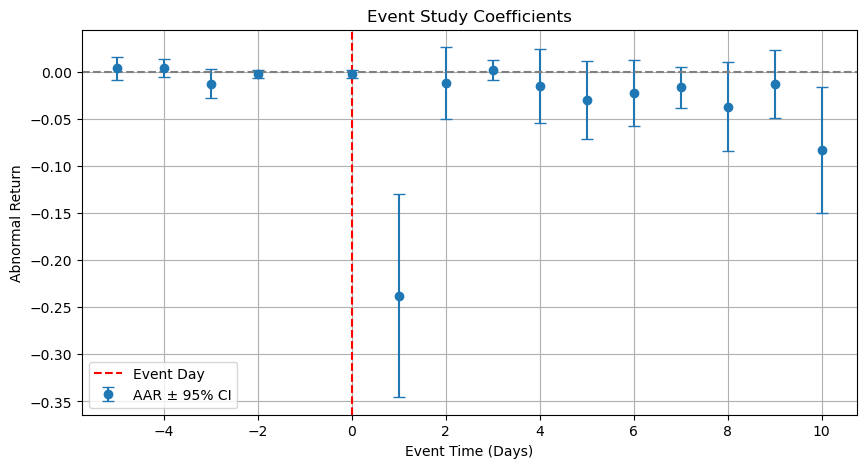

In [419]:
# Strip to coefficients only.
coef = model.params.drop('const', errors='ignore')
stderr = model.bse.drop('const', errors='ignore')

event_days = [int(col.split('_')[1].replace('.0', '')) for col in coef.index]
coef_df = pd.DataFrame({
    'event_day': event_days,
    'coef': coef.values,
    'stderr': stderr.values
}).sort_values('event_day')

# Plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(coef_df['event_day'], coef_df['coef'], yerr=1.96 * coef_df['stderr'],
            fmt='o', capsize=4, label='AAR ± 95% CI')

ax.axhline(0, color='gray', linestyle='--')
ax.axvline(0, color='red', linestyle='--', label='Event Day')
ax.set_xlabel('Event Time (Days)')
ax.set_ylabel('Abnormal Return')
ax.set_title('Event Study Coefficients')
ax.legend()
plt.grid(True)
plt.show()


## Effects of Bond Issuance on Firm Operations